# Wrangle & Analyze Data

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import time
import datetime
import random

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

# set the option to display the full string from a pandas DataFrame
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

## Data Gathering

#### Twitter Archive (Local File)

In [2]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

##### Sample Tweet Data

Here is a sample of one of the tweets, with additional output to display the entire field's data.

In [3]:
sample_tweet = df_twitter_archive.iloc[7]
sample_tweet

tweet_id                      890729181411237888                                                                                                                            
in_reply_to_status_id         NaN                                                                                                                                           
in_reply_to_user_id           NaN                                                                                                                                           
timestamp                     2017-07-28 00:22:40 +0000                                                                                                                     
source                        <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>                                                            
text                          When you watch your owner call another dog a good boy but then they turn back to you and say you're a gre

In [4]:
sample_tweet.text 

"When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq"

In [5]:
sample_tweet.expanded_urls

'https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1'

In [6]:
sample_tweet.source

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

#### Image Predictions File (URL)

In [7]:
# download the image predictions file with the provided link
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [8]:
#  HTTP status code 200 indicates the request has succeeded 
file_images = url.split('/')[-1]

with open(os.path.join('./', file_images), mode = 'wb') as file:
    file.write(response.content)

In [9]:
ls *.tsv

image-predictions.tsv


In [10]:
# read image predictions file into a DataFrame
df_predictions = pd.read_csv(file_images, sep = '\\t', engine = 'python')
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [11]:
df_predictions.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [12]:
# check one observation
df_predictions.iloc[2]

tweet_id    666033412701032449                             
jpg_url     https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
img_num     1                                              
p1          German_shepherd                                
p1_conf     0.596461                                       
p1_dog      True                                           
p2          malinois                                       
p2_conf     0.138584                                       
p2_dog      True                                           
p3          bloodhound                                     
p3_conf     0.116197                                       
p3_dog      True                                           
Name: 2, dtype: object

#### Download Tweet JSON Data

> I queried the Twitter API using Python's Tweepy library to get the entire set of JSON data for each of the tweets in the WeRateDogs Twitter archive. Each tweet's JSON data is written to its own line in a file called tweet_json.txt file.

#### Personal Twitter  API keys, Secrets, and Tokens

In [13]:
CONSUMER_KEY = '4yjr0C6Jy5n9chjaQjqxkOHMQ'
CONSUMER_SECRET = 'qs048gLsKVyJQQYd0z0AJYymSOatqFCpWKwZI8tX5apoNC4Bjp'
OAUTH_TOKEN = '1173440055915900928-e8QS89Gs16KmN40zATiR65ZBBEzhNB'
OAUTH_TOKEN_SECRET = 'zAffsxn9UNPKh5M7fVK0wmT6LLR6tL2CdVXk40W7STiUU'

In [14]:
# Create the Twitter API object and set rate limit params

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

api = tweepy.API(auth_handler = auth, 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

#### Download tweets

In [ ]:
# Get a list of tweet_ids from the enhanced twitter archive to use for 
# downloading with the Twitter API

tweet_ids = df_twitter_archive.tweet_id.values
print("# of tweet_ids: " + str(len(tweet_ids)) + "\n")

count = 0
tweet_json_list = []
fails_dict = {}

start_time = time.time()

for tweet_id in tweet_ids:
    count += 1
    try:
        # attempt to get the tweet's JSON data and append to the tweet JSON list
        tweet = api.get_status(tweet_id, tweet_mode = 'extended')
        tweet_json_list.append(tweet._json)
    except tweepy.TweepError as err:
        # save the error to the fail dictionary for review
        print("TweepError for id:  " + str(tweet_id))
        fails_dict[tweet_id] = err
        pass
    # To save space, only print out loop/tweet id for every 100th tweet
    if count % 100 == 0:
        print("loop # " + str(count))

elapsed_time = time.time() - start_time

elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print("\nTime elapsed (HH:MM:SS):  " + elapsed_time_str + "\n")

# display list of tweets with errors
print("Number of TweepErrors:  {}\n".format(len(fails_dict)))
for tweet_id in fails_dict:
    print(tweet_id, fails_dict[tweet_id])

#### Save JSON data to file

In [17]:
tweet_json_file = 'tweet_json.txt'

In [18]:
# save the JSON data in the list to the output file
with open(tweet_json_file, 'w') as outfile:
    for tweet_json in tweet_json_list:
        json.dump(tweet_json, outfile)
        outfile.write('\n')

In [19]:
ls tweet_json.txt

tweet_json.txt


#### Read in JSON data to DataFrame
Extract the required fields from each tweet's JSON data and store in a separate file, tweet_data_extra.csv, for use during the assessment phase.

In [23]:
# read in the JSON data from the text file, and save to a DataFrame
tweet_json_data = []

with open(tweet_json_file, 'r') as json_file:
    # read the first line to start the loop
    line = json_file.readline()
    while line:
        data = json.loads(line)

        # extract variables from the JSON data
        data_id = data['id']
        data_retweet_count = data['retweet_count']
        data_favorite_count = data['favorite_count']
        
        # create a dictionary with the JSON data, then add to a list
        json_data = {'tweet_id': data_id, 
                     'retweet_count': data_retweet_count, 
                     'favorite_count': data_favorite_count
                    }
        tweet_json_data.append(json_data)

        # read the next line of JSON data
        line = json_file.readline()
        # ----- while -----

# convert the tweet JSON data dictionary list to a DataFrame
df_tweet_data_extra = pd.DataFrame(tweet_json_data, 
                                   columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

df_tweet_data_extra.head(10)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8330,38089
1,892177421306343426,6154,32679
2,891815181378084864,4073,24595
3,891689557279858688,8474,41449
4,891327558926688256,9167,39623
5,891087950875897856,3052,19898
6,890971913173991426,2024,11624
7,890729181411237888,18488,64265
8,890609185150312448,4190,27333
9,890240255349198849,7229,31363


In [24]:
df_tweet_data_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null int64
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [25]:
df_tweet_data_extra.to_csv('tweet_data_extra.csv', index = False)

## Data Assessment

In [26]:
# Load the data gathered data files
archive = pd.read_csv('twitter-archive-enhanced.csv')
predictions = pd.read_csv('image-predictions.tsv', sep = '\\t', engine = 'python')
json_data = pd.read_csv('tweet_data_extra.csv')

### archive

In [27]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

---
**NOTES:**

The `info()` method reveals several quality and tidiness issues:

- There are 181 retweets (**retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp**)
- There are 78 replies (**in_reply_to_status_id, in_reply_to_user_id**)
- There are 2297 tweets with **expanded_urls** (links to images) indicating 59 tweets with missing data
- The **timestamp** field is in string format (object)
- There are 4 columns for dog stages (**doggo, floofer, pupper, puppo**)
- The columns related to retweets are not applicable for original tweets
- The columns related to replies are not applicable for original tweets

In [28]:
print("Data type for timestamp:  " + str(type(archive.timestamp[0])))

Data type for timestamp:  <class 'str'>


In [29]:
print("Duplicated:  {}".format(sum(archive.duplicated())))

Duplicated:  0


In [153]:
archive.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [154]:
archive.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


**NOTES:**
> The `head()` and `tail()` methods show us several issues:
>
> Quality:
> - The **timestamp** column has dates in string form.
> - Some of the rows from the `tail()` output above have invalid strings in the **name** column, e.g. "a", "an", "in". These words are all the 3rd word in the tweet.
> - Values of "None" in the **name** column.
>
> Tidiness:
> - The columns with numerical data that are typically used for analysis are located to the far right of the table, and the columns with long strings are on the left; this makes it difficult to readily see the data that will be used for analyses.

---
#### `name`
> First we'll check the **name** column, starting with value counts.

In [32]:
archive.name.value_counts().head(50)

None        745
a           55 
Charlie     12 
Cooper      11 
Oliver      11 
Lucy        11 
Penny       10 
Tucker      10 
Lola        10 
Winston     9  
Bo          9  
Sadie       8  
the         8  
an          7  
Buddy       7  
Toby        7  
Daisy       7  
Bailey      7  
Oscar       6  
Rusty       6  
Dave        6  
Koda        6  
Leo         6  
Jax         6  
Scout       6  
Milo        6  
Jack        6  
Bella       6  
Stanley     6  
Alfie       5  
Chester     5  
Oakley      5  
Finn        5  
Gus         5  
George      5  
Bentley     5  
Larry       5  
Sammy       5  
very        5  
Louis       5  
Sunny       5  
Phil        5  
Gary        4  
Bear        4  
Sophie      4  
Jeffrey     4  
Ruby        4  
Clarence    4  
Scooter     4  
Bruce       4  
Name: name, dtype: int64

**NOTES:**

> It looks like the dog names are all capitalized, so words that begin in lowercase are probably not names, like "a", "the" and "an". Here's the list of these "names".

In [33]:
# list all names that are NOT capitalized
err_names_mask = archive.name.str.contains('^[a-z]', regex = True)
archive[err_names_mask].name.value_counts().sort_index()

a               55
actually        2 
all             1 
an              7 
by              1 
getting         2 
his             1 
incredibly      1 
infuriating     1 
just            4 
life            1 
light           1 
mad             2 
my              1 
not             2 
officially      1 
old             1 
one             4 
quite           4 
space           1 
such            1 
the             8 
this            1 
unacceptable    1 
very            5 
Name: name, dtype: int64

In [34]:
len(archive[err_names_mask])

109

**NOTES:**

> This list contains non-capitalized words from the **name** column for 109 tweets, none of which are a valid name.

---
#### `expanded_urls`
> Next, check the tweets that are missing data in **expanded_urls**, are they replies or retweets?

In [35]:
# number of tweets with missing urls
sum(archive.expanded_urls.isna())

59

In [36]:
# how many tweets with missing urls are replies or retweets?
sum(archive.expanded_urls.isna() & \
    (archive.in_reply_to_status_id.notnull() | \
     archive.retweeted_status_id.notnull()))

56

In [37]:
# display tweets that are missing urls, and are NOT replies and are NOT retweets
mask = archive.expanded_urls.isna() & \
       archive.in_reply_to_status_id.isna() & \
       archive.retweeted_status_id.isna()
archive[mask][['tweet_id', 'text', 'expanded_urls']]

,tweet_id,text,expanded_urls
375,828361771580813312,Beebop and Doobert should start a band 12/10 would listen,NaN
707,785515384317313025,"Today, 10/10, should be National Dog Rates Day",NaN
1445,696518437233913856,Oh my god 10/10 for every little hot dog pupper,NaN


**NOTES:**

> Of the 59 tweets that are missing data in **expanded_urls**, 56 are replies or retweets. The remaining 3 tweets (at indexes 375, 707 and 1445) with NaN in the **expanded_urls** column all have valid ratings but no urls within the **text** column.
>
> The question now is whether these tweets are part of the **predictions** or **json_data** tables.

In [38]:
# are any of these tweets in the predictions table?
tweet_set = [828361771580813312, 785515384317313025, 696518437233913856]
find_tweet_id = predictions.tweet_id.isin(tweet_set)
sum(find_tweet_id)

0

In [39]:
# are any of these tweets in the json_data table?
tweet_set = [828361771580813312, 785515384317313025, 696518437233913856]
find_tweet_id = json_data.tweet_id.isin(tweet_set)
json_data[find_tweet_id]

,tweet_id,retweet_count,favorite_count
366,828361771580813312,184,2323
695,785515384317313025,1376,6527
1430,696518437233913856,1814,4086


**NOTES:**

> It turns out that these 3 tweets are NOT in the **predictions** table, and even though they ARE in the **json_data** table, there was NO image url extracted from the JSON data.

---
#### `rating_numerator` and `rating_denominator`

In [40]:
archive[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


**NOTES:**
> For **rating_numerator** and **rating_denominator**, the `describe()` method shows us some quality issues:
>
> - The max values are huge: 1776, 170.
> - The minimum is 0 for both.

In [41]:
archive.rating_denominator.value_counts().sort_index(ascending = False)

170    1   
150    1   
130    1   
120    1   
110    1   
90     1   
80     2   
70     1   
50     3   
40     1   
20     2   
16     1   
15     1   
11     3   
10     2333
7      1   
2      1   
0      1   
Name: rating_denominator, dtype: int64

In [42]:
sum(archive.rating_denominator != 10)

23

**NOTES:**

> It's interesting that many of the larger numbers are multiples of 10. When looking at some of those tweets we see that there is more than 1 dog in the photo. Ignoring the retweets and replies we have the following list.

In [43]:
# display tweets that do NOT have denominator of 10,
# and are NOT replies and are NOT retweets
mask_find = (archive.rating_denominator != 10) & \
            archive.in_reply_to_status_id.isna() & \
            archive.retweeted_status_id.isna()

mask_cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator']
archive[mask_find][mask_cols]

,text,tweet_id,rating_numerator,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,820690176645140481,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,810984652412424192,24,7
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,758467244762497024,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",740373189193256964,9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,731156023742988288,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,722974582966214656,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,716439118184652801,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,713900603437621249,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,710658690886586372,80,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",709198395643068416,45,50


In [44]:
sum(mask_find)

17

**NOTES:**

> Ignoring the replies and retweets, there are 17 tweets with denominators that aren't 10.
>
> Many of these which are multiples of 10 are about multiple dogs, and the text indicates this, like "floofs", "puppers", "squad" and "pups". I'll just drop the tweets for multiples, but I'll reset the rating for single dogs.

 | index | tweet_id | original rating | multiple? | revised rating | comment |
 | --- | --- | --- | --- | --- | --- |
 | 433  | - |  84/70 | yes | 12/10 | drop; multiple dogs |
 | 516  | - | 24/7 | no | None | drop; no rating |
 | 902  | - | 165/150 | yes | 11/10 | drop; multiple dogs |
 | 1068 | 740373189193256964 | 9/11 | no | 14/10 | **manual fix** |
 | 1120 | - |  204/170 | yes | 12/10 | drop; multiple dogs |
 | 1165 | - |  4/20 | yes | 13/10 | drop; multiple dogs |
 | 1202 | 716439118184652801 | 50/50 | no | 11/10 | **manual fix** |
 | 1228 | - |  99/90 | yes | 11/10 | drop; multiple dogs |
 | 1254 | - |  80/80 | yes | 10/10 | drop; multiple dogs |
 | 1274 | - |  45/50 | yes | 9/10 | drop; multiple dogs |
 | 1351 | - |  60/50 | yes | 12/20 | drop; multiple dogs |
 | 1433 | - |  44/40 | yes | 11/10 | drop; multiple dogs |
 | 1635 | - |  121/110 | yes | 11/10 | drop; multiple dogs |
 | 1662 | 682962037429899265 | 7/11 | no | 10/10 | **manual fix** |
 | 1779 | - |  144/120 | yes | 12/10 | drop; multiple dogs |
 | 1843 | - |  88/80 | yes | 11/10 | drop; multiple dogs |
 | 2335 | 666287406224695296 | 1/2 | no | 9/10 | **manual fix** |


#### `rating_numerator`

In [45]:
archive.rating_numerator.value_counts().sort_index(ascending = False)

1776    1  
960     1  
666     1  
420     2  
204     1  
182     1  
165     1  
144     1  
143     1  
121     1  
99      1  
88      1  
84      1  
80      1  
75      2  
60      1  
50      1  
45      1  
44      1  
27      1  
26      1  
24      1  
20      1  
17      1  
15      2  
14      54 
13      351
12      558
11      464
10      461
9       158
8       102
7       55 
6       32 
5       37 
4       17 
3       19 
2       9  
1       9  
0       2  
Name: rating_numerator, dtype: int64

In [46]:
sum(archive.rating_numerator >= 15)

28

**NOTES:**

> The output above shows ALL the **rating_numerator** values, showing a count of 28 tweets with numerator >= 15. Next, looking at ONLY those ratings with denominators = 10, the results are as follows:

In [47]:
df_tweets_denom_10 = archive[archive.rating_denominator == 10]
df_tweets_denom_10.rating_numerator.value_counts().sort_index(ascending = False)

1776    1  
666     1  
420     2  
182     1  
75      2  
27      1  
26      1  
17      1  
15      2  
14      54 
13      351
12      558
11      463
10      461
9       156
8       102
7       54 
6       32 
5       37 
4       15 
3       19 
2       9  
1       8  
0       2  
Name: rating_numerator, dtype: int64

In [48]:
sum(df_tweets_denom_10.rating_numerator >= 15)

12

**NOTES:**

> Looking ONLY at tweets that have denominators = 10, there are 12 with numerators >= 15. I chose 15 as the lower boundary because it's got just 2 counts, while 14 has a count of 54. We can check the texts to see if the numerator makes sense.
>
> NOTE: The next queries ignore retweets and replies.

In [49]:
# display tweets with numerator >= 15 that DO have denominator of 10,
# and are NOT replies and are NOT retweets
mask_find = (archive.rating_denominator == 10) & \
            (archive.rating_numerator >= 15) & \
            archive.in_reply_to_status_id.isna() & \
            archive.retweeted_status_id.isna()

mask_cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator']
archive[mask_find][mask_cols]

,text,tweet_id,rating_numerator,rating_denominator
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",786709082849828864,75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,778027034220126208,27,10
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,749981277374128128,1776,10
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,680494726643068929,26,10
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,670842764863651840,420,10


**NOTES:**

> Here we have 5 tweets (excluding retweets and replies) with denominator = 10 and numerator >= 15. Looking at the text column we see ratings with decimals or huge numbers.
>
> Since there are so few, and I don't want to impose a rating myself, I'll ignore these tweets and drop them.

In [50]:
# display tweets with numerator = 0 that DO have denominator of 10,
# and are NOT replies and are NOT retweets
mask_find = (archive.rating_denominator == 10) & \
            (archive.rating_numerator == 0) & \
            archive.in_reply_to_status_id.isna() & \
            archive.retweeted_status_id.isna()

mask_cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator']
archive[mask_find][mask_cols]

,text,tweet_id,rating_numerator,rating_denominator
315,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,835152434251116546,0,10


> And lastly, here is a tweet with numerator (rating) of '0'. It looks legit!

#### `source`

In [51]:
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

**NOTES:**
> There are only 4 types of sources, and they can be simplified by using the display string portion just before the final "<\a>":
 - Twitter for iPhone
 - Vine - Make a Scene
 - Twitter Web Client
 - TweetDeck

#### `doggo`, `floofer`, `pupper`, and `puppo`

In [52]:
archive.doggo.value_counts()

None     2259
doggo    97  
Name: doggo, dtype: int64

In [53]:
archive.floofer.value_counts()

None       2346
floofer    10  
Name: floofer, dtype: int64

In [54]:
archive.pupper.value_counts()

None      2099
pupper    257 
Name: pupper, dtype: int64

In [55]:
archive.puppo.value_counts()

None     2326
puppo    30  
Name: puppo, dtype: int64

In [56]:
archive[archive.floofer == 'floofer'].text

46      Meet Grizzwald. He may be the floofiest floofer I ever did see. Lost eyes saving a schoolbus from a volcano erpuption. 13/10 heroic as h*ck https://t.co/rf661IFEYP 
200     At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
582     This is Doc. He takes time out of every day to worship our plant overlords. 12/10 quite the floofer https://t.co/azMneS6Ly5                                         
774     Atlas rolled around in some chalk and now he's a magical rainbow floofer. 13/10 please never take a bath https://t.co/nzqTNw0744                                    
984     This is Blu. He's a wild bush Floofer. I wish anything made me as happy as bushes make Blu. 12/10 would frolic with https://t.co/HHUAnBb6QB                         
1022    Here's a golden floofer helping with the groceries. Bed got in way. Still 11/10 helpful af (vid by @categoen) https://t.co/6ZRo

**NOTES:**
> Using the floofer category as an example, it looks like there are a few ways that this type is spelled: "floofer", "floofiest", and "Floofer".  
The other dog stage types may be similar in the variety of spelling.

---
<a id='assess_predictions'></a>
### `predictions`

In [57]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [58]:
predictions.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [59]:
predictions.p1_dog.value_counts()

True     1532
False    543 
Name: p1_dog, dtype: int64

In [60]:
predictions.p2_dog.value_counts()

True     1553
False    522 
Name: p2_dog, dtype: int64

In [61]:
predictions.p3_dog.value_counts()

True     1499
False    576 
Name: p3_dog, dtype: int64

In [62]:
# check out 20 of the entries that don't predict dogs
predictions[~predictions.p1_dog & \
               ~predictions.p2_dog & \
               ~predictions.p3_dog][['tweet_id', 'p1', 'p1_dog',
                                        'p2', 'p2_dog', 'p3', 'p3_dog']].head(20)

,tweet_id,p1,p1_dog,p2,p2_dog,p3,p3_dog
6,666051853826850816,box_turtle,False,mud_turtle,False,terrapin,False
17,666104133288665088,hen,False,cock,False,partridge,False
18,666268910803644416,desktop_computer,False,desk,False,bookcase,False
21,666293911632134144,three-toed_sloth,False,otter,False,great_grey_owl,False
25,666362758909284353,guinea_pig,False,skunk,False,hamster,False
29,666411507551481857,coho,False,barracouta,False,gar,False
45,666786068205871104,snail,False,slug,False,acorn,False
50,666837028449972224,triceratops,False,armadillo,False,common_iguana,False
51,666983947667116034,swab,False,chain_saw,False,wig,False
53,667012601033924608,hyena,False,African_hunting_dog,False,coyote,False


In [63]:
sum(~predictions.p1_dog & \
    ~predictions.p2_dog & \
    ~predictions.p3_dog)

324

**NOTES:**
> In each of the prediction columns there are over 500 instances where the algorithm did not predict a dog breed from the image. When combined, there are 324 cases where there is NO valid dog breed from any of the three predictions.
>
> The best prediction for dog breed could be combined with the twitter archive table; this is essentially another variable pertaining to the dog on which the archive is based.

---
<a id='assess_json_data'></a>
### `json_data`

In [64]:
json_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null int64
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [65]:
json_data.head(20)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8330,38089
1,892177421306343426,6154,32679
2,891815181378084864,4073,24595
3,891689557279858688,8474,41449
4,891327558926688256,9167,39623
5,891087950875897856,3052,19898
6,890971913173991426,2024,11624
7,890729181411237888,18488,64265
8,890609185150312448,4190,27333
9,890240255349198849,7229,31363


In [66]:
json_data.describe()

,tweet_id,retweet_count,favorite_count
count,2.340000e+03,2340.000000,2340.000000
mean,7.422176e+17,2934.637607,7976.021795
std,6.832564e+16,4943.049421,12350.111679
min,6.660209e+17,0.000000,0.000000
25%,6.783394e+17,590.000000,1377.500000
50%,7.186224e+17,1371.000000,3470.500000
75%,7.986954e+17,3420.750000,9766.250000
max,8.924206e+17,83795.000000,164524.000000


<a id='clean'></a>

---
## Clean Data

In [67]:
# create copies of the dataframes for cleaning
archive_clean = archive.copy()
predictions_clean = predictions.copy()
json_data_clean = json_data.copy()

In [68]:
len_archive = archive_clean.shape[0]; len_archive

2356

<a id='clean_qa1'></a>
### Quality `archive` #1.
There are 181 retweets, and we’re only interested in “original tweets”.

##### Define
> Drop all rows containing retweets, where these columns will be non-null: `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`.

##### Code

In [69]:
print("# of retweets:  {}".format(sum(archive_clean.retweeted_status_id.notnull())))

# of retweets:  181


In [70]:
archive_clean = archive_clean[archive_clean.retweeted_status_id.isna()]

##### Test

In [71]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [72]:
# confirm the rows are dropped; compare with original table length
print("# of rows dropped:  {}".format(len_archive - archive_clean.shape[0]))
# reset the variable for length of the archive
len_archive = archive_clean.shape[0]

# of rows dropped:  181


---
<a id='clean_qa2'></a>
### Quality `archive` #2.
There are 78 reply tweets; we’re only interested in “original tweets”.

##### Define
> Drop all rows that are replies, those that have non-null values in these columns: `in_reply_to_status_id` and `in_reply_to_user_id`.
##### Code

In [73]:
print("# of replies:  {}".format(sum(archive_clean.in_reply_to_status_id.notnull())))

# of replies:  78


In [74]:
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isna()]

##### Test

In [75]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

In [76]:
# confirm the rows are dropped; compare with previous table length
print("# of rows dropped:  {}".format(len_archive - archive_clean.shape[0]))
# reset the variable for length of the archive
len_archive = archive_clean.shape[0]

# of rows dropped:  78


---
<a id='clean_ta2'></a>
### Tidiness `archive` #2.
All columns related to “retweets” will be empty (we're not interested in retweets).

##### Define
> Since we don't want retweets, we can drop all columns related to retweets: `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`.

##### Code

In [77]:
archive_clean = archive_clean.drop(['retweeted_status_id',
                                    'retweeted_status_user_id',
                                    'retweeted_status_timestamp'], axis = 1)

##### Test

In [78]:
# Confirm all retweet related columns are gone
list(archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

---
<a id='clean_ta3'></a>
### Tidiness `archive` #3.
All columns related to “replies” will be empty (we're not interested in replies).


##### Define
> Drop all columns related to replies: `in_reply_to_status_id` and `in_reply_to_user_id`.
##### Code

In [79]:
archive_clean = archive_clean.drop(['in_reply_to_status_id',
                                    'in_reply_to_user_id'], axis = 1)

##### Test

In [80]:
# Confirm all reply related columns are gone
list(archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

---
<a id='clean_qa4'></a>
### Quality `archive` #4.
The *timestamp* column is in string format, it's the wrong data type.

##### Define
> Convert `timestamp` to datetime data type.
##### Code

In [81]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean.timestamp)
archive_clean['timestamp'] = archive_clean.timestamp.dt.floor('s')

##### Test

In [82]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(8)
memory usage: 213.0+ KB


---
<a id='clean_qa9'></a>
### Quality `archive` #9.
The *source* column can be simplified by extracting and replacing with it's display string.

#### Define
> Replace the `source` string with the display portion of itself. Extract the string between `<a href="">` and `</a>`.
#### Code

In [83]:
archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     31  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [84]:
archive_clean['source'] = archive_clean['source'].str.extract('^<a.+>(.+)</a>$')

#### Test

In [85]:
archive_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene    91  
Twitter Web Client     31  
TweetDeck              11  
Name: source, dtype: int64

---
<a id='clean_qa7-1'></a>
### Quality `archive` \#7 - Part 1.
Some tweets have wrong values extracted for rating; text contains the tweeter's rating.

##### Define
> Manual fix:
- 740373189193256964: replace 9/11 with 14/10
- 716439118184652801: replace 50/50 with 11/10
- 682962037429899265: replace 7/11 with 10/10
- 666287406224695296: replace 1/2 with 9/10

##### Code

In [86]:
mask_row = archive_clean.tweet_id == 740373189193256964
archive_clean.loc[mask_row, 'rating_numerator'] = 14
archive_clean.loc[mask_row, 'rating_denominator'] = 10

In [87]:
mask_row = archive_clean.tweet_id == 716439118184652801
archive_clean.loc[mask_row, 'rating_numerator'] = 11
archive_clean.loc[mask_row, 'rating_denominator'] = 10

In [88]:
mask_row = archive_clean.tweet_id == 682962037429899265
archive_clean.loc[mask_row, 'rating_numerator'] = 10
archive_clean.loc[mask_row, 'rating_denominator'] = 10

In [89]:
mask_row = archive_clean.tweet_id == 666287406224695296
archive_clean.loc[mask_row, 'rating_numerator'] = 9
archive_clean.loc[mask_row, 'rating_denominator'] = 10

##### Test

In [90]:
mask_cols = ['tweet_id', 'text', 'rating_numerator', 'rating_denominator']
archive_clean[(archive_clean.tweet_id == 740373189193256964) | \
              (archive_clean.tweet_id == 716439118184652801) | \
              (archive_clean.tweet_id == 682962037429899265) | \
              (archive_clean.tweet_id == 666287406224695296) ][mask_cols]

,tweet_id,text,rating_numerator,rating_denominator
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10
1662,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,10,10
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9,10


---
<a id='clean_qa7-2'></a>
### Quality `archive` \#7 - Part 2.
Some tweets with *rating_denominator* NOT equal to 10; multiple dogs or no valid rating.

##### Define
> Drop the remaining tweets with `rating_denominator` values that are NOT equal to 10.
##### Code

In [91]:
# display denominators
archive_clean.rating_denominator.value_counts().sort_index(ascending = False)

170    1   
150    1   
120    1   
110    1   
90     1   
80     2   
70     1   
50     2   
40     1   
20     1   
10     2084
7      1   
Name: rating_denominator, dtype: int64

In [92]:
archive_clean = archive_clean[archive_clean.rating_denominator == 10]

##### Test

In [93]:
# check the values in the column - should only be "10"
archive_clean.rating_denominator.value_counts().sort_index(ascending = False)

10    2084
Name: rating_denominator, dtype: int64

---
<a id='clean_qa8'></a>
### Quality `archive` #8.
There are 5 tweets with *rating_numerator* >= 15, which either don't make sense or are huge.

##### Define
> Drop tweets that have `rating_numerator` >= 15.
##### Code

In [94]:
# display numerators greater than 15
mask = archive_clean.rating_numerator >= 15
archive_clean[mask].rating_numerator.value_counts().sort_index(ascending = False)

1776    1
420     1
75      1
27      1
26      1
Name: rating_numerator, dtype: int64

In [95]:
archive_clean = archive_clean[archive_clean.rating_numerator < 15]

##### Test

In [96]:
# display ALL numerators
archive_clean.rating_numerator.value_counts().sort_index(ascending = False)

14    39 
13    287
12    486
11    414
10    437
9     153
8     98 
7     51 
6     32 
5     34 
4     15 
3     19 
2     9  
1     4  
0     1  
Name: rating_numerator, dtype: int64

---
<a id='clean_qa3'></a>
### Quality `archive` #3.
Tweets with missing data in *expanded_urls* (links to the tweet).

##### Define
> Drop tweets with missing data in the `expanded_urls`.
##### Code

In [97]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2079 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2079 non-null int64
timestamp             2079 non-null datetime64[ns, UTC]
source                2079 non-null object
text                  2079 non-null object
expanded_urls         2076 non-null object
rating_numerator      2079 non-null int64
rating_denominator    2079 non-null int64
name                  2079 non-null object
doggo                 2079 non-null object
floofer               2079 non-null object
pupper                2079 non-null object
puppo                 2079 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(8)
memory usage: 211.1+ KB


In [98]:
archive_clean = archive_clean[archive_clean.expanded_urls.notnull()]

##### Test

In [99]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2076 non-null int64
timestamp             2076 non-null datetime64[ns, UTC]
source                2076 non-null object
text                  2076 non-null object
expanded_urls         2076 non-null object
rating_numerator      2076 non-null int64
rating_denominator    2076 non-null int64
name                  2076 non-null object
doggo                 2076 non-null object
floofer               2076 non-null object
pupper                2076 non-null object
puppo                 2076 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(8)
memory usage: 210.8+ KB


---
<a id='clean_ta1'></a>
### Tidiness `archive` #1.
There are 4 columns for dog stages: `doggo`, `floofer`, `pupper`, `puppo`.

##### Define
> Melt the 4 columns with the dog stages:
 - Create a temporary column called `none` to store the `None` values; use lowercase 'n' to avoid confusion with 'None' special NA value.
 - Create a new column `stage` to store the categories: `doggo`, `floofer`, `pupper`, `puppo`, as well as `None`, and select the stage from the column that contains a value.
 - Cast the `stage` column to categorical data type.
 - Drop the 4 original dog stage columns, and the temporary `none` column.

##### Code

In [100]:
archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].describe()

,doggo,floofer,pupper,puppo
count,2076,2076,2076,2076
unique,2,2,2,2
top,None,None,None,None
freq,1993,2066,1848,2052


**NOTE:**
> From the describe() output here, I'm going to order the dog stages by count, in increasing order: floofer, puppo, doggo and pupper.

In [101]:
# replace the stage name with 1, and 'None' with 0, like a dummy variable
make_dummy = lambda x: 0 if x == 'None' else 1

archive_clean.doggo = archive_clean.doggo.apply(make_dummy)
archive_clean.floofer = archive_clean.floofer.apply(make_dummy)
archive_clean.pupper = archive_clean.pupper.apply(make_dummy)
archive_clean.puppo = archive_clean.puppo.apply(make_dummy)

# by adding the stage columns, we can see how many are 'none' and how many stages are set
archive_clean['none'] = archive_clean['doggo'] + archive_clean['floofer'] + \
                        archive_clean['pupper'] + archive_clean['puppo']

# have a look at what we have before we continue...
archive_clean['none'].value_counts()

0    1742
1    323 
2    11  
Name: none, dtype: int64

**NOTE:**
> Here we have a little surprise! Turns out there are 11 tweets that have 2 dog stages set, so these must be tweets about multiple dogs. As there are only 11 entries, I'll just carry on with selecting the first of the dog stages in increasing count order - floofer, puppo, doggo and pupper - so we don't loose too much information.

In [102]:
# if there are NO stages specified then set 'None' to 1
stage_none = lambda x: 1 if x == 0 else 0

# reset values in 'none' 
archive_clean['none'] = archive_clean['none'].apply(stage_none)

# Order the stages in increasing count order: floofer, puppo, doggo and pupper
# set the choice order for dog stage based on count order
stage = ['floofer', 'puppo', 'doggo', 'pupper', 'none']

# set the conditions for selecting the dog stage based on count order
conditions = [
    (archive_clean[stage[0]] == 1),
    (archive_clean[stage[1]] == 1),
    (archive_clean[stage[2]] == 1),
    (archive_clean[stage[3]] == 1),
    (archive_clean[stage[4]] == 1)]

# select the dog stage based on the first successful condition; stage[4] is 'None'
archive_clean['stage'] = np.select(conditions, stage, default = stage[4])

# now we can drop the original 4 dog stage columns, AND the temporary 'None'
archive_clean.drop(stage, axis = 1, inplace = True)

# set the 'stage' column data type to category
archive_clean['stage'] = archive_clean.stage.astype('category')

# Source for algorithm:    https://code.i-harness.com/en/q/19c9fbc

##### Test

In [103]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2076 non-null int64
timestamp             2076 non-null datetime64[ns, UTC]
source                2076 non-null object
text                  2076 non-null object
expanded_urls         2076 non-null object
rating_numerator      2076 non-null int64
rating_denominator    2076 non-null int64
name                  2076 non-null object
stage                 2076 non-null category
dtypes: category(1), datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 148.2+ KB


In [104]:
archive_clean.stage.value_counts()

none       1742
pupper     219 
doggo      81  
puppo      24  
floofer    10  
Name: stage, dtype: int64

---
<a id='clean_qj1'></a>
<a id='clean_tj1'></a>
### Tidiness `json_data` #1. & Quality `json_data` #1.
The `json_data` table should be part of the `archive` table.

There is also missing data for these fields which is handled in the **Additional Cleaning** part just below.

##### Define
> Merge the `retweet_count` and `favorite_count` columns to the **archive** table, joining on `tweet_id`.
##### Code

In [105]:
json_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null int64
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [106]:
archive_clean = pd.merge(archive_clean, json_data_clean, 
                         on = 'tweet_id', how = 'left')

##### Test

In [107]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2075
Data columns (total 11 columns):
tweet_id              2076 non-null int64
timestamp             2076 non-null datetime64[ns, UTC]
source                2076 non-null object
text                  2076 non-null object
expanded_urls         2076 non-null object
rating_numerator      2076 non-null int64
rating_denominator    2076 non-null int64
name                  2076 non-null object
stage                 2076 non-null category
retweet_count         2074 non-null float64
favorite_count        2074 non-null float64
dtypes: category(1), datetime64[ns, UTC](1), float64(2), int64(3), object(4)
memory usage: 180.6+ KB


#### Additional Cleaning
The merge of the **json_data** table with the **archive** table caused the data types for `retweet_count` and `favorite_count` to change from int64 to float64. There is also missing data for these fields.

##### Define
> - Drop tweets with missing **json_data**.
> - Change the data type for the `retweet_count` and `favorite_count` to be int.
##### Code

In [108]:
mask_cols = ['tweet_id', 'retweet_count', 'favorite_count']
archive_clean[archive_clean.retweet_count.isna() | archive_clean.favorite_count.isna()][mask_cols]

,tweet_id,retweet_count,favorite_count
720,754011816964026368,NaN,NaN
1470,680055455951884288,NaN,NaN


In [109]:
archive_clean = archive_clean[~(archive_clean.retweet_count.isna() | archive_clean.favorite_count.isna())]

# recast the count columns to int type
archive_clean.retweet_count = archive_clean.retweet_count.astype(int)
archive_clean.favorite_count = archive_clean.favorite_count.astype(int)

##### Test

In [110]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2074 entries, 0 to 2075
Data columns (total 11 columns):
tweet_id              2074 non-null int64
timestamp             2074 non-null datetime64[ns, UTC]
source                2074 non-null object
text                  2074 non-null object
expanded_urls         2074 non-null object
rating_numerator      2074 non-null int64
rating_denominator    2074 non-null int64
name                  2074 non-null object
stage                 2074 non-null category
retweet_count         2074 non-null int64
favorite_count        2074 non-null int64
dtypes: category(1), datetime64[ns, UTC](1), int64(5), object(4)
memory usage: 180.5+ KB


---
<a id='clean_qa5'></a>
### Quality `archive` #5.
There are many tweets with regular words in the *name* column that are NOT a valid name.

##### Define
> Replace all lowercase words in the `name` column with the string "none".
##### Code

In [111]:
names_mask = archive_clean.name.str.contains('^[a-z]', regex = True)
archive_clean[names_mask].name.value_counts().sort_index()

a               54
actually        2 
all             1 
an              6 
by              1 
getting         2 
his             1 
incredibly      1 
infuriating     1 
just            3 
life            1 
light           1 
mad             1 
my              1 
not             2 
officially      1 
old             1 
one             4 
quite           3 
space           1 
such            1 
the             8 
unacceptable    1 
very            4 
Name: name, dtype: int64

In [112]:
archive_clean.loc[names_mask, 'name'] = "none"

##### Test

In [113]:
# All these entries were changed to "none"
archive_clean[names_mask].name.value_counts().sort_index()

none    102
Name: name, dtype: int64

---
<a id='clean_tp3'></a>
### Tidiness `predictions` #3.
The _best_ dog breed prediction and associated confidence level can be combined with the `archive` table; these pieces of information provide additional data about the dog in the tweet based on the tweet's image.

_**NOTE:** We only want to keep tweets that have images._

_**NOTE:** This also solves_ **Quality `predictions` \#1** _issue, that there are fewer image predictions than tweets in the archive._

##### Define
> This is a 2-step process, first creating the columns in the **predictions** table, then merging to **archive**.
>
> Part 1:
> - Create two new columns in **predictions** called `breed` and `confidence`: check each dog breed prediction flag in order (`p1_dog`, `p2_dog`, `p3_dog`), and copy the breed with the highest confidence level into the `breed` column.
> - Copy the associated confidence level into the new `confidence` column.
> - For cases where all 3 prediction flags are False (NOT a valid dog breed), set `breed` as 'none' and `confidence` to 0.
>
> Part 2:
> - Merge the new `breed` and `confidence` columns into the tweet **archive** table, using an 'inner' join so that we are left with only tweets _with_ images.
> - Now we can fix the `confidence` column; round the values up to a whole number in percentage format.

##### Code - Part 1

In [114]:
# Source:    https://code.i-harness.com/en/q/19c9fbc

# setup the conditions for selection
conditions = [(predictions_clean['p1_dog'] == True),
              (predictions_clean['p2_dog'] == True),
              (predictions_clean['p3_dog'] == True)]

# set the choice order based on the selection conditions for predicted breed
choices_breed = [predictions_clean['p1'], 
                 predictions_clean['p2'],
                 predictions_clean['p3']]

# set the choice order for confidence level based on the selection conditions
choices_confidence = [predictions_clean['p1_conf'], 
                      predictions_clean['p2_conf'], 
                      predictions_clean['p3_conf']]

# select the predicted breed based on the first successful condition
predictions_clean['breed'] = np.select(conditions, choices_breed, 
                                       default = 'none')

# select the predicted confidence level based on the first successful condition
predictions_clean['confidence'] = np.select(conditions, choices_confidence, 
                                            default = 0)

##### Test - Part 1

In [115]:
predictions_clean.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True,Bernese_mountain_dog,0.651137
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False,none,0.000000
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False,chow,0.692517
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True,golden_retriever,0.007959
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True,miniature_poodle,0.201493


##### Code - Part 2

In [116]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2074 entries, 0 to 2075
Data columns (total 11 columns):
tweet_id              2074 non-null int64
timestamp             2074 non-null datetime64[ns, UTC]
source                2074 non-null object
text                  2074 non-null object
expanded_urls         2074 non-null object
rating_numerator      2074 non-null int64
rating_denominator    2074 non-null int64
name                  2074 non-null object
stage                 2074 non-null category
retweet_count         2074 non-null int64
favorite_count        2074 non-null int64
dtypes: category(1), datetime64[ns, UTC](1), int64(5), object(4)
memory usage: 180.5+ KB


In [117]:
# merge the breed and confidence columns to archive
mask_cols = ['tweet_id', 'breed', 'confidence']
archive_clean = pd.merge(archive_clean, predictions_clean[mask_cols],
                         on = 'tweet_id', how = 'inner')

# change data type for the confidence interval to a rounded, whole integer (%)
archive_clean.confidence = (archive_clean.confidence * 100).astype(int)

# after the two columns are merged, we can drop them from the 'predictions' table
predictions_clean.drop(['breed', 'confidence'], axis = 1, inplace = True)

##### Test - Part 2

In [118]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 0 to 1950
Data columns (total 13 columns):
tweet_id              1951 non-null int64
timestamp             1951 non-null datetime64[ns, UTC]
source                1951 non-null object
text                  1951 non-null object
expanded_urls         1951 non-null object
rating_numerator      1951 non-null int64
rating_denominator    1951 non-null int64
name                  1951 non-null object
stage                 1951 non-null category
retweet_count         1951 non-null int64
favorite_count        1951 non-null int64
breed                 1951 non-null object
confidence            1951 non-null int64
dtypes: category(1), datetime64[ns, UTC](1), int64(6), object(5)
memory usage: 200.2+ KB


In [119]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,breed,confidence
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,none,8330,38089,none,0
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,none,6154,32679,Chihuahua,32
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,none,4073,24595,Chihuahua,71
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,none,8474,41449,Labrador_retriever,16
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,none,9167,39623,basset,55


In [120]:
list(predictions_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

---
<a id='clean_qj2'></a>
<a id='clean_qp1'></a>
### Quality `json_data` \#2.  &  Quality `predictions` \#1.
We only want to keep tweets that have images.

_**NOTE:** Both of these issues were resolved just above at the same time as for_ **Tidiness `predictions` \#3**.

##### Define
> **Nothing to do here.**


---
<a id='clean_ta4'></a>
### Tidiness `archive` #4.
All values in the `rating_denominator` column are 10, so we don't need this column any more, and the `rating_numerator` column can be renamed `rating`.

##### Define
> - Drop the `rating_denominator` column.
> - Rename the `rating_numerator` column to be `rating`.

##### Code

In [121]:
archive_clean.rating_denominator.value_counts()

10    1951
Name: rating_denominator, dtype: int64

In [122]:
archive_clean.drop(['rating_denominator'], axis = 1, inplace = True)
archive_clean.rename(index = str, columns = {'rating_numerator': 'rating'}, inplace = True)

##### Test

In [123]:
list(archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating',
 'name',
 'stage',
 'retweet_count',
 'favorite_count',
 'breed',
 'confidence']

---
<a id='clean_ta5'></a>
### Tidiness `archive` \#5.
Columns with numerical data are located to the far right of the table, which makes it difficult to readily see the data that will be used for analyses.

##### Define
> - Reorder the column placement: bring numerical columns to the left.
> - Drop the `expanded_urls` column.

##### Code

In [124]:
col_list = list(archive_clean.columns)
print(col_list)

['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating', 'name', 'stage', 'retweet_count', 'favorite_count', 'breed', 'confidence']


In [125]:
# set the columns in a new order
col_list = ['tweet_id', 'timestamp', 'rating', 'retweet_count', 'favorite_count',
            'breed', 'confidence', 'name', 'stage', 'source', 'text']

archive_clean = archive_clean[col_list]

##### Test

In [126]:
archive_clean.head(2)

,tweet_id,timestamp,rating,retweet_count,favorite_count,breed,confidence,name,stage,source,text
0,892420643555336193,2017-08-01 16:23:56+00:00,13,8330,38089,none,0,Phineas,none,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1,892177421306343426,2017-08-01 00:17:27+00:00,13,6154,32679,Chihuahua,32,Tilly,none,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"


---
## Store Data
The cleaned twitter archive data in `archive_clean` is ready for the analysis phase. The `predictions_clean` and `json_data_clean` tables have not been cleaned as they will not be used again. Now we store the `archive_clean` table into the 'twitter_archive_master.csv' file.

In [127]:
archive_clean.to_csv('twitter_archive_master.csv', index = False)

In [128]:
ls *.csv

tweet_data_extra.csv  twitter-archive-enhanced.csv  twitter_archive_master.csv


---
<a id='analyze'></a>
## Analyze Data

The following analyses, tables and plots, are created with the cleaned data from the previous section. The variables that are used primarily - rating, timestamp, retweet_count, favorite_count and breed - have all undergone cleaning to varying degrees.

In [129]:
# Set default display parameter for plots.
plt.rcParams['figure.figsize'] = (8, 5)

In [130]:
# make a copy of the archive master table for analysis
we_rate_dogs = archive_clean.copy()
we_rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1951 entries, 0 to 1950
Data columns (total 11 columns):
tweet_id          1951 non-null int64
timestamp         1951 non-null datetime64[ns, UTC]
rating            1951 non-null int64
retweet_count     1951 non-null int64
favorite_count    1951 non-null int64
breed             1951 non-null object
confidence        1951 non-null int64
name              1951 non-null object
stage             1951 non-null category
source            1951 non-null object
text              1951 non-null object
dtypes: category(1), datetime64[ns, UTC](1), int64(5), object(4)
memory usage: 169.8+ KB


In [131]:
# time range for tweets
we_rate_dogs.timestamp.min(), we_rate_dogs.timestamp.max()

(Timestamp('2015-11-15 22:32:08+0000', tz='UTC'),
 Timestamp('2017-08-01 16:23:56+0000', tz='UTC'))

### Simple Statistics
First some simple questions to ask about the WeRateDogs tweets:

In [132]:
we_rate_dogs[['rating', 'retweet_count', 'favorite_count', 'confidence']].describe()

,rating,retweet_count,favorite_count,confidence
count,1951.000000,1951.000000,1951.000000,1951.000000
mean,10.538698,2677.820092,8819.283957,46.103024
std,2.175013,4775.448373,12923.497863,33.820024
min,0.000000,12.000000,80.000000,0.000000
25%,10.000000,592.000000,1874.000000,14.000000
50%,11.000000,1277.000000,3970.000000,45.000000
75%,12.000000,3058.500000,10986.500000,77.000000
max,14.000000,83795.000000,164524.000000,99.000000


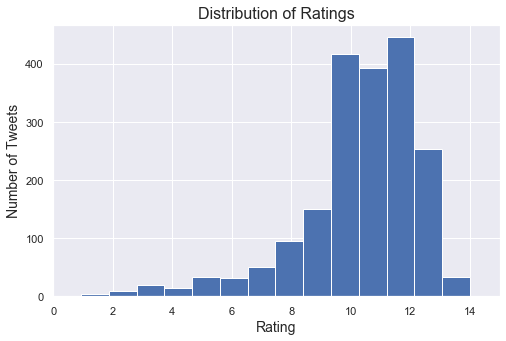

In [133]:
we_rate_dogs['rating'].plot(kind = 'hist', bins = 15)

plt.xlim(0, 15)
plt.ylabel('Number of Tweets', fontsize = 14)
plt.xlabel('Rating', fontsize = 14)
plt.title('Distribution of Ratings', fontsize = 16)
plt.show();

The distribution of ratings is very skewed to the left. From the descriptive statistics above we see that 75% of all ratings are between 10 and 14 inclusive (the IQR is from 10 to 12).

In [134]:
# Percentage of tweets with rating of 10 and up
rating_10up_total = sum(we_rate_dogs.rating >= 10)
rating_10up_perc = round(rating_10up_total * 100 / we_rate_dogs.shape[0])
print("Number of tweets with rating 10+:  {}".format(rating_10up_total))
print("Percentage of tweets:                {}%".format(round(rating_10up_perc, 3)))

Number of tweets with rating 10+:  1542
Percentage of tweets:                79%


In [135]:
# How many tweets have favorite count <= retweet count?
sum(we_rate_dogs.favorite_count <= we_rate_dogs.retweet_count)

0

#### What is the most favourited tweet to date? Top 5?

In [136]:
we_rate_dogs.sort_values(by = 'favorite_count', ascending = False).head(5)

,tweet_id,timestamp,rating,retweet_count,favorite_count,breed,confidence,name,stage,source,text
762,744234799360020481,2016-06-18 18:26:18+00:00,13,83795,164524,Labrador_retriever,82,None,doggo,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
306,822872901745569793,2017-01-21 18:26:02+00:00,13,47772,140616,Lakeland_terrier,19,None,puppo,Twitter for iPhone,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc
395,807106840509214720,2016-12-09 06:17:20+00:00,13,61068,127238,Chihuahua,50,Stephan,none,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d
108,866450705531457537,2017-05-22 00:28:40+00:00,13,35492,122083,French_bulldog,90,Jamesy,pupper,Twitter for iPhone,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr"
797,739238157791694849,2016-06-04 23:31:25+00:00,13,62062,121530,Eskimo_dog,50,None,doggo,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC


#### What is the most retweeted tweet to date? Top 5.

In [137]:
we_rate_dogs.sort_values(by = 'retweet_count', ascending = False).head(5)

,tweet_id,timestamp,rating,retweet_count,favorite_count,breed,confidence,name,stage,source,text
762,744234799360020481,2016-06-18 18:26:18+00:00,13,83795,164524,Labrador_retriever,82,None,doggo,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
797,739238157791694849,2016-06-04 23:31:25+00:00,13,62062,121530,Eskimo_dog,50,None,doggo,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC
395,807106840509214720,2016-12-09 06:17:20+00:00,13,61068,127238,Chihuahua,50,Stephan,none,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d
306,822872901745569793,2017-01-21 18:26:02+00:00,13,47772,140616,Lakeland_terrier,19,None,puppo,Twitter for iPhone,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc
58,879415818425184262,2017-06-26 19:07:24+00:00,13,43498,104162,English_springer,38,Duddles,none,Twitter for iPhone,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY


There are 4 tweets that are in the top 5 for both variables, but the most popular tweet is also the _same_ as the most retweeted tweet; it has been retweeted over 83,000 times and favourited over 164,000 times! 

#### What is the most common stage?

In [138]:
we_rate_dogs.stage.value_counts()

none       1649
pupper     200 
doggo      71  
puppo      23  
floofer    8   
Name: stage, dtype: int64

In [139]:
with_stage_sum = sum(we_rate_dogs.stage != 'none')
tweets_with_stage = round(with_stage_sum * 100 / we_rate_dogs.shape[0])
print("Number of tweets WITH stage:  {}".format(with_stage_sum))
print("Percentage of tweets:          {}%".format(round(tweets_with_stage, 3)))

Number of tweets WITH stage:  302
Percentage of tweets:          15%


Only a small proportion of tweets with dog stages identified.

#### What are the 10 most common breeds of dogs tweeted about? (Excluding the category 'none'.)

In [140]:
str = "Number of tweets with 'none' predicted breed:  {} ({}%)"
none_count = sum(we_rate_dogs.breed == 'none')
none_perc = none_count * 100 / we_rate_dogs.shape[0]
print(str.format(none_count, round(none_perc)))

str = "Number of distinct breeds:  {}"
print(str.format(len(we_rate_dogs.breed.unique())))

Number of tweets with 'none' predicted breed:  302 (15%)
Number of distinct breeds:  113


In [141]:
top10_breeds_count = \
we_rate_dogs[we_rate_dogs.breed != 'none'].breed.value_counts().head(10)
print("Breed and number of tweets")
print("--------------------------")
print(top10_breeds_count)

top10_per = round(sum(top10_breeds_count) * 100 / we_rate_dogs.shape[0])
print("\nTop 10 dog breeds make up {}% of all tweets".format(top10_per))

Breed and number of tweets
--------------------------
golden_retriever      154
Labrador_retriever    103
Pembroke              94 
Chihuahua             90 
pug                   62 
toy_poodle            50 
chow                  47 
Samoyed               41 
Pomeranian            40 
malamute              33 
Name: breed, dtype: int64

Top 10 dog breeds make up 37% of all tweets


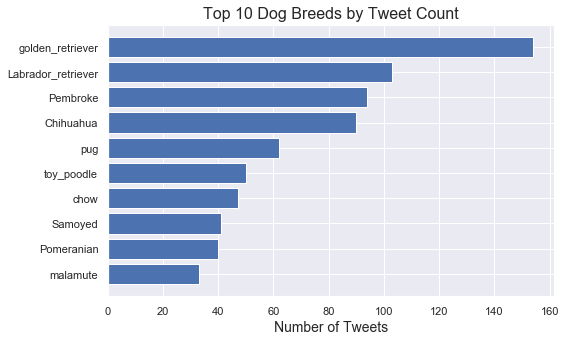

In [142]:
plt.barh(top10_breeds_count.index, top10_breeds_count)

plt.xlabel('Number of Tweets', fontsize = 14)
# plt.ylabel('Dog Breed', fontsize = 14)
plt.title('Top 10 Dog Breeds by Tweet Count', fontsize = 16)
plt.gca().invert_yaxis()
plt.show();

### Bivariate Analysis

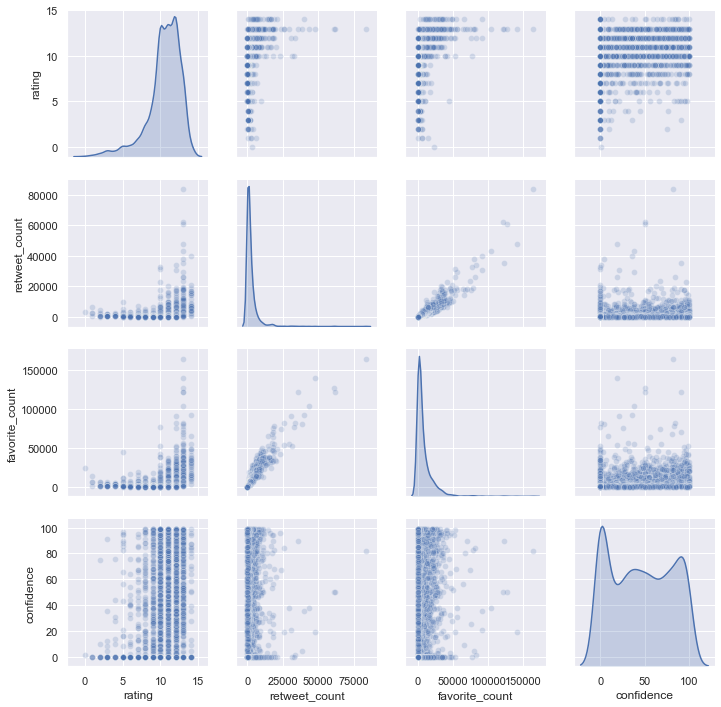

In [143]:
sns.pairplot(we_rate_dogs, 
             vars = ['rating', 'retweet_count', 'favorite_count', 'confidence'], 
             diag_kind = 'kde', plot_kws = {'alpha': 0.2});

#### What dog breeds have the highest overall favourite counts?

In [144]:
fav_counts_breed = we_rate_dogs[we_rate_dogs.breed != 'none']
fav_counts_breed = fav_counts_breed.groupby(['breed'])
fav_counts_breed = fav_counts_breed['favorite_count'].sum()
fav_counts_breed = fav_counts_breed.sort_values(ascending = False)
top10_breeds_fav_counts = fav_counts_breed.head(10)
top10_breeds_fav_counts

breed
golden_retriever      1887444
Labrador_retriever    1241894
Pembroke              1017644
Chihuahua             755370 
French_bulldog        589850 
Samoyed               543358 
chow                  436997 
cocker_spaniel        398924 
pug                   368502 
malamute              344208 
Name: favorite_count, dtype: int64

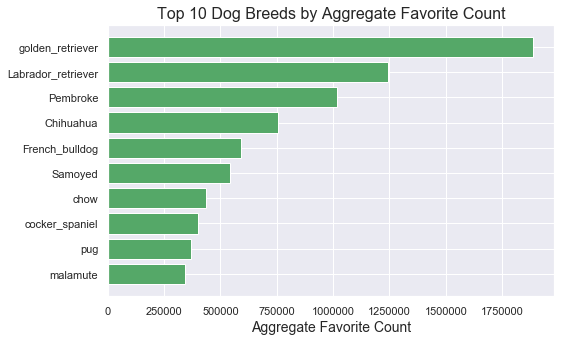

In [145]:
plt.barh(top10_breeds_fav_counts.index, top10_breeds_fav_counts, color = 'g')

plt.xlabel('Aggregate Favorite Count', fontsize = 14)
# plt.ylabel('Dog Breed', fontsize = 12)
plt.title('Top 10 Dog Breeds by Aggregate Favorite Count', fontsize = 16)
plt.gca().invert_yaxis()
plt.show();

In [146]:
list(set(top10_breeds_count.index) & set(top10_breeds_fav_counts.index))

['Labrador_retriever',
 'Samoyed',
 'Pembroke',
 'chow',
 'pug',
 'golden_retriever',
 'Chihuahua',
 'malamute']

#### How are ratings distributed within each of the dog breeds with highest favourite counts?

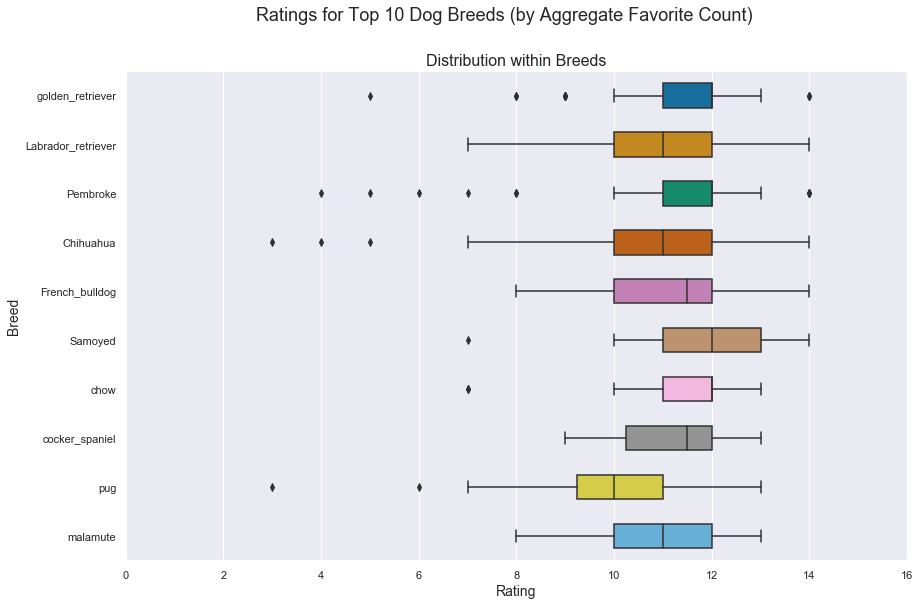

In [147]:
plt.figure(figsize = (14, 9))
bplot = sns.boxplot(y = 'breed', x = 'rating',
                    data = we_rate_dogs,
                    orient = 'h',
                    width = 0.5,
                    palette = "colorblind",
                    order = top10_breeds_fav_counts.index.tolist())
plt.xlim(0, 16)

# title and labels
plt.suptitle('Ratings for Top 10 Dog Breeds (by Aggregate Favorite Count)', fontsize = 18)
plt.title('Distribution within Breeds', fontsize = 16)
plt.ylabel("Breed",  fontsize = 14)
plt.xlabel('Rating',  fontsize = 14)
# plt.yticks(rotation = 60,  fontsize = 12)
plt.show()

The boxplot here shows the distribution of ratings within each of the top 10 dog breeds as ranked by aggregate favourite count. All the breeds range between 7 and 13, with a only a few outliers, while four of the breeds have the lower ratings at 10. Another four breeds have the highest ratings at 14.

#### How are tweet ratings distributed by day?

In [148]:
# Add random amount of float between [0.0:0.7) to input x
def jitter(x):
    random.seed()
    return x + random.uniform(0, 0.7)

In [149]:
# Return the number of days from a timedelta object x
def days_from_start(x):
    return x.days

# start date
first_day = we_rate_dogs.timestamp.min()

# array with days corresponding to timestamp
we_rate_dogs_days = (we_rate_dogs.timestamp - first_day).apply(days_from_start)

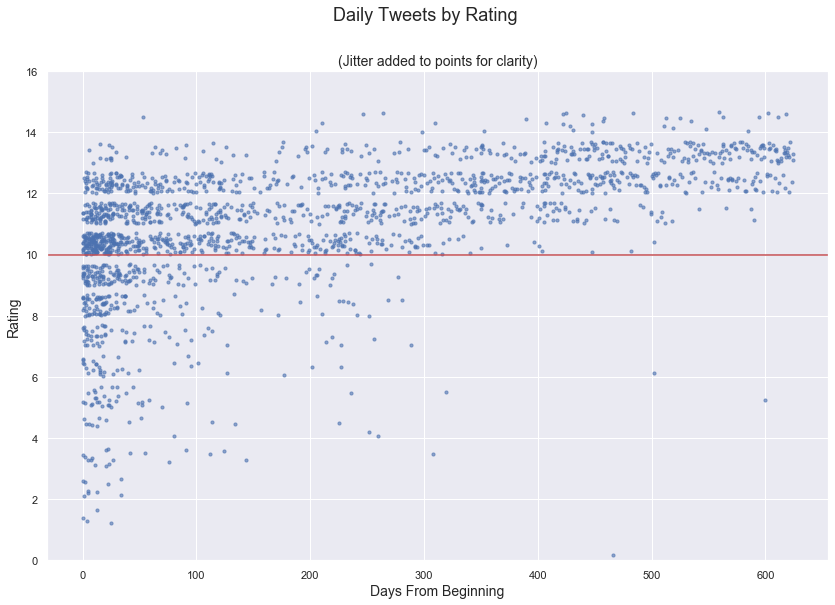

In [150]:
plt.figure(figsize = (14, 9))

# add jitter to the rating so it's not so cluttered on each line
rating_jitter = we_rate_dogs.rating.apply(jitter)

plt.scatter(we_rate_dogs_days, rating_jitter, s = 10, alpha = 0.6)

# title and labels
plt.suptitle('Daily Tweets by Rating', fontsize = 18)
plt.title('(Jitter added to points for clarity)', fontsize = 14)

plt.xlabel('Days From Beginning', fontsize = 14)
plt.ylabel('Rating', fontsize = 14)

# add the line at 10 for reference; ratings are out of 10
plt.axhline(y = 10, color = 'r')
plt.ylim(0, 16)

plt.show();

The plot here has the tweet ratings by day, showing how the ratings are generally over 10 in the latter half of the time period, after the account has been running for 300 days.

### Multivariate Analysis
#### Relationship between favourite and retweet counts with dog rating as colour.

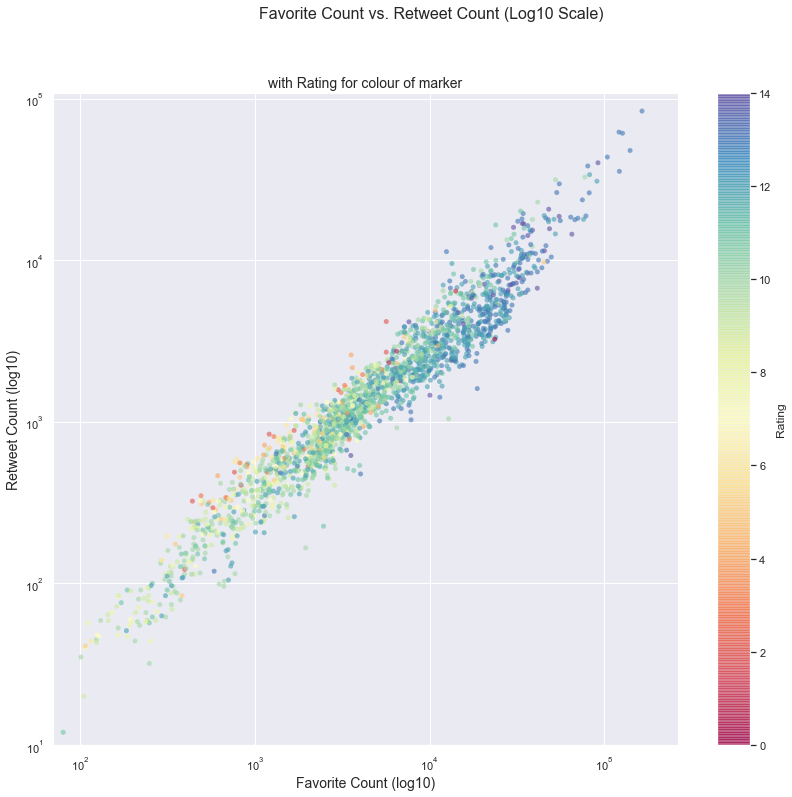

In [151]:
# Adapted from an answer from: 
# https://stackoverflow.com/questions/25741214/how-to-use-colormaps-to-color-plots-of-pandas-dataframes
# -------------------------------------------------------------------------

df = we_rate_dogs

cmap = cm.get_cmap('Spectral') # Colour map (there are many others)
plt.figure(figsize = (14, 12))

plt.xscale('log')
plt.yscale('log')
plt.xlim(df['favorite_count'].min() - 10, df['favorite_count'].max() + 100000)
plt.ylim(10, df['retweet_count'].max() + 25000)
colours = df['rating']
markers = 25

plt.scatter(df['favorite_count'], df['retweet_count'], 
            c = colours, s = markers, cmap = cmap, edgecolor = 'None', alpha = 0.6)

# title and labels
plt.suptitle('Favorite Count vs. Retweet Count (Log10 Scale)', fontsize = 16)
plt.title('with Rating for colour of marker', fontsize = 14)
plt.xlabel('Favorite Count (log10)', fontsize = 14)
plt.ylabel('Retweet Count (log10)', fontsize = 14)

# colour bar
cbar = plt.colorbar()
cbar.set_label('Rating')

plt.show();

#### Favourite counts over time, with dog rating as colour.

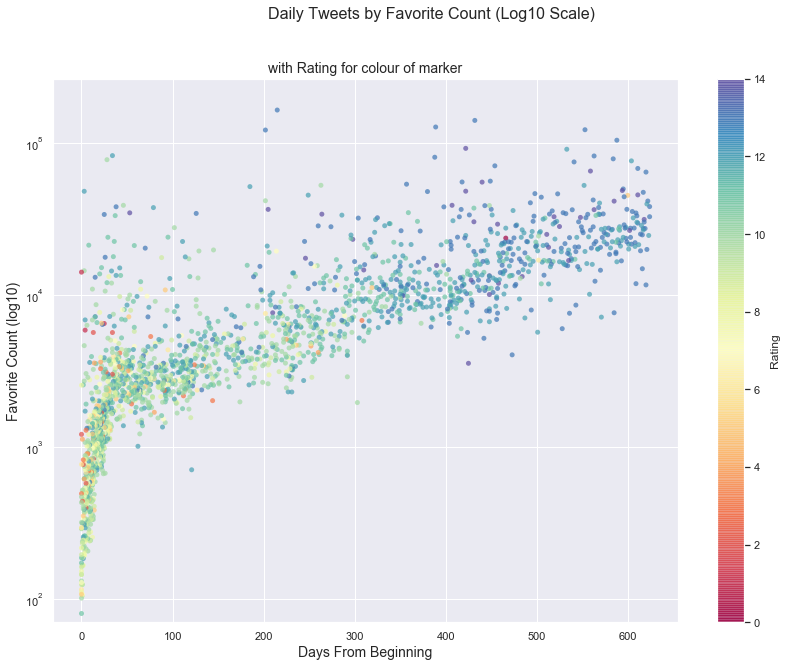

In [152]:
# Adapted from an answer from: 
# https://stackoverflow.com/questions/25741214/how-to-use-colormaps-to-color-plots-of-pandas-dataframes
# -------------------------------------------------------------------------

cmap = cm.get_cmap('Spectral') # Colour map (there are many others)
plt.figure(figsize = (14, 10))

plt.yscale('log')
plt.ylim(we_rate_dogs['favorite_count'].min() - 10, 
         we_rate_dogs['favorite_count'].max() + 100000)
colours = we_rate_dogs['rating']
markers = 25

plt.scatter(we_rate_dogs_days, we_rate_dogs['favorite_count'], 
            c = colours, s = markers, cmap = cmap, edgecolor = 'None', alpha = 0.7)

# title and labels
plt.suptitle('Daily Tweets by Favorite Count (Log10 Scale)', fontsize = 16)
plt.title('with Rating for colour of marker', fontsize = 14)
plt.xlabel('Days From Beginning', fontsize = 14)
plt.ylabel('Favorite Count (log10)', fontsize = 14)

cbar = plt.colorbar()
cbar.set_label('Rating')
plt.show();